# Credit Risk Model Training
 
This notebook demonstrates:
1. Train/test split
2. Random Forest model training with hyperparameter tuning
3. Model evaluation

In [1]:
%load_ext autoreload

In [94]:
%autoreload 2

In [95]:
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [96]:
# Import dependencies
%matplotlib inline
import scorecardpy as sc
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path
sys.path.append("../scripts/")
from model import split_data, train_model, evaluate_model


In [97]:
# Load LABELED data
# 1. Define paths
LABELED_DIR = Path("../data/processed")
LABELED_DATA = LABELED_DIR / "labeled_data.parquet"

df = pd.read_parquet(LABELED_DATA)
print("labeled data shape:", df.shape)
df.head()

# Verify target exists
assert 'Label' in df.columns, "Missing target column!"



labeled data shape: (3742, 17)


In [98]:
print(df['Label'].value_counts())


Label
Bad     2650
Good    1092
Name: count, dtype: int64


## 1. Prepare Data for Modeling

In [99]:
# Separate features and target
X = df.drop(['CustomerId', 'Label'], axis=1)
y = df['Label']

# Split data
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (2993, 15), Test shape: (749, 15)


In [100]:
print(X_train.dtypes)

TotalAmount                     float64
AvgAmount                       float64
TransactionCount                  int64
StdAmount                       float64
FirstTransaction    datetime64[ns, UTC]
LastTransaction     datetime64[ns, UTC]
TransactionMonth              period[M]
DaysActive                        int64
Recency                           int64
Frequency                         int64
Monetary                        float64
Stability                         int64
RecencyScore                      int64
MonetaryScore                     int64
RFM_Score                         int64
dtype: object


In [101]:
def preprocess_data(X):
    # Step 1: Convert datetime columns to numeric
    if 'FirstTransaction' in X.columns:
        if X['FirstTransaction'].dt.tz is None:
            X['FirstTransaction'] = X['FirstTransaction'].dt.tz_localize('UTC')
        X['DaysSinceFirst'] = (pd.Timestamp.now(tz='UTC') - X['FirstTransaction']).dt.days
        X.drop('FirstTransaction', axis=1, inplace=True)

    if 'LastTransaction' in X.columns:
        if X['LastTransaction'].dt.tz is None:
            X['LastTransaction'] = X['LastTransaction'].dt.tz_localize('UTC')
        X['DaysSinceLast'] = (pd.Timestamp.now(tz='UTC') - X['LastTransaction']).dt.days
        X.drop('LastTransaction', axis=1, inplace=True)

    if 'TransactionMonth' in X.columns:
        X['TransactionYear'] = X['TransactionMonth'].dt.year
        X['TransactionMonth'] = X['TransactionMonth'].dt.month  
        X.drop('TransactionMonth', axis=1, inplace=True)  

    # Step 3: Check for any remaining NaN values
    X.fillna(method='ffill', inplace=True)

    return X

# Preprocess both training and test sets
X_train_processed = preprocess_data(X_train)
X_test_processed = preprocess_data(X_test)



## 2. Train Random Forest Model

In [102]:
# Train model with hyperparameter tuning
rf_model = train_model(X_train_processed, y_train, model_type='rf')
print("Best parameters:", rf_model.get_params())



Best parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


## 3. Model Evaluation

In [103]:
# Evaluate performance
metrics = evaluate_model(rf_model, X_test_processed, y_test)
print("\nModel Performance:")
print(f"Accuracy: {metrics['accuracy']:.2f}")
print(f"ROC AUC: {metrics['roc_auc']:.2f}")




Model Performance:
Accuracy: 1.00
ROC AUC: 1.00


Cross-Validated Accuracy: 1.0


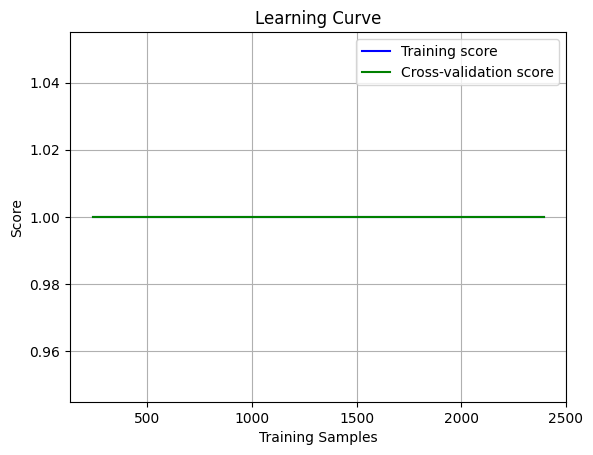

In [104]:
from sklearn.model_selection import cross_val_score, learning_curve
import matplotlib.pyplot as plt

# 1. Cross-validation to check for overfitting
cv_scores = cross_val_score(rf_model, X_train_processed, y_train, cv=5, scoring='accuracy')
print("Cross-Validated Accuracy:", cv_scores.mean())

# 2. Learning curve
train_sizes, train_scores, test_scores = learning_curve(rf_model, X_train_processed, y_train, 
                                                         train_sizes=np.linspace(0.1, 1.0, 10), 
                                                         scoring='accuracy', random_state=42)

# Calculate the average and standard deviation of training and test scores
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='green')
plt.title('Learning Curve')
plt.xlabel('Training Samples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.show()

## 4. Feature Importance Analysis

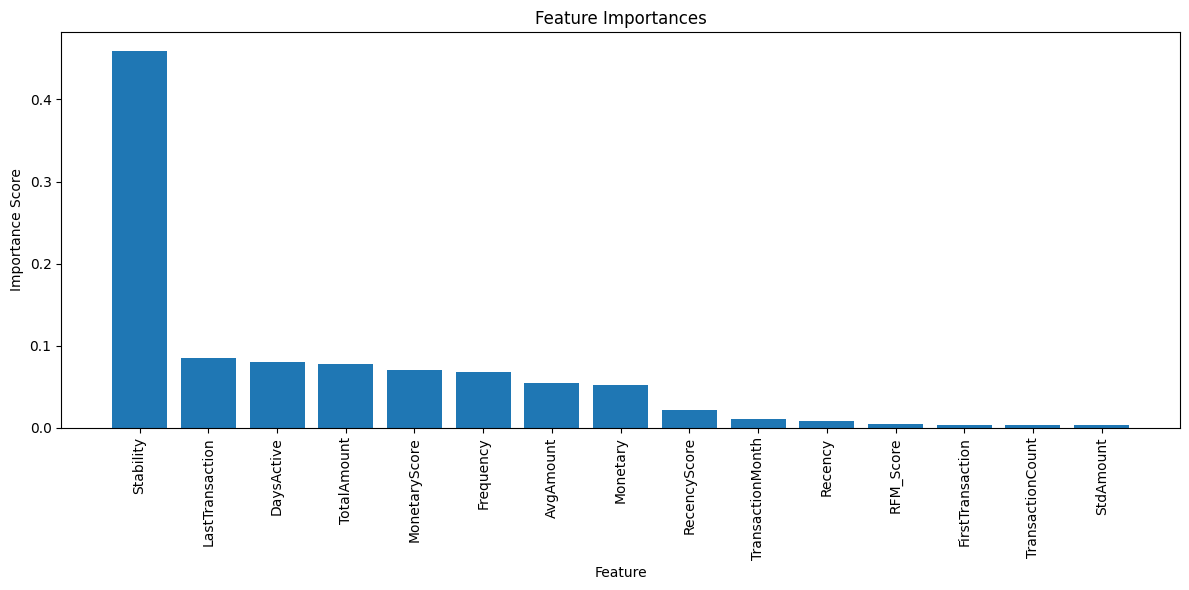

In [105]:
# Plot feature importances
importances = rf_model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()



## 5. Save Trained Model

In [106]:
import joblib

MODEL_PATH = "../models/credit_risk_model.pkl"
joblib.dump(rf_model, MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to ../models/credit_risk_model.pkl
